In [1]:
from itertools import islice
import random

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import LagHyenaEstimator


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/libbitsandbytes_cuda122.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 122
CUDA SETUP: Loading binary /home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/libbitsandbytes_cuda122.so...


/home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)


[2023-07-27 12:07:00,082] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [5]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [6]:
gluonts_ds = [
        get_dataset("airpassengers").train,
        get_dataset("australian_electricity_demand").train,
        get_dataset("car_parts_without_missing").train,
        get_dataset("cif_2016").train,
        get_dataset("covid_deaths").train,
        get_dataset("electricity").train,
        get_dataset("electricity_weekly").train,
        get_dataset("exchange_rate").train,
        get_dataset("fred_md").train,
        get_dataset("hospital").train,
        get_dataset("kaggle_web_traffic_weekly").train,
        get_dataset("kdd_cup_2018_without_missing").train,
        get_dataset("london_smart_meters_without_missing").train,
        get_dataset("nn5_daily_with_missing").train,
        get_dataset("nn5_weekly").train,
        get_dataset("pedestrian_counts").train,
        get_dataset("rideshare_without_missing").train,
        get_dataset("saugeenday").train,
        get_dataset("solar-energy").train,
        get_dataset("solar_10_minutes").train,
        get_dataset("solar_weekly").train,
        get_dataset("taxi_30min").train,
        get_dataset("temperature_rain_without_missing").train,
        get_dataset("tourism_monthly").train,
        get_dataset("uber_tlc_daily").train,
        get_dataset("uber_tlc_hourly").train,
        get_dataset("vehicle_trips_without_missing").train,
        get_dataset("weather").train,
        get_dataset("wiki-rolling_nips").train,
        get_dataset("m4_daily").train,
        get_dataset("m4_hourly").train,
        get_dataset("m4_monthly").train,
        get_dataset("m4_quarterly").train,
        get_dataset("m4_yearly").train,
        get_dataset("wind_farms_without_missing").train,
]
dataset = CombinedDataset(gluonts_ds, weights=[sum([len(x["target"]) for x in d]) for d in gluonts_ds])

In [7]:
val_dataset = get_dataset("m4_weekly").test

In [8]:
test_dataset = get_dataset("traffic")

In [32]:
estimator = LagHyenaEstimator(
        prediction_length=test_dataset.metadata.prediction_length,
        context_length=test_dataset.metadata.prediction_length*10,
        n_embd=64,
        n_layer=2,
        scaling="std",
    
        aug_prob=0.5,
            
        batch_size=16,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(
            accelerator="gpu", 
            precision="bf16-mixed",
            max_epochs=300,
        ),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_20/checkpoints/epoch=3-step=400.ckpt',
    )

In [33]:
predictor = estimator.train(
    training_data=dataset,
    shuffle_buffer_length=1024,
    validation_data=val_dataset,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | LagHyenaModel | 145 K 
----------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     Total params
0.581     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached -2.89960 (best -2.89960), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_20/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached -3.07352 (best -3.07352), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_20/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached -3.10986 (best -3.10986), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_20/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached -3.13486 (best -3.13486), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-hyena/lightning_logs/version_20/checkpoints/epoch=3-step=400.ckpt' as top 1


In [34]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset.test,
    predictor=predictor,
)

In [35]:
forecasts = list(forecast_it)

In [23]:
tss = list(ts_it)

In [36]:
evaluator = Evaluator()

In [37]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 6034it [00:00, 92889.63it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [38]:
agg_metrics

{'MSE': 0.0005592300270659622,
 'abs_error': 1388.393738117069,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 0.6274162597703209,
 'MAPE': 0.3184828937033003,
 'sMAPE': 0.18734774684467417,
 'MSIS': 7.1001341197678896,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 634.1438023617477,
 'Coverage[0.1]': 0.04892415202740028,
 'QuantileLoss[0.2]': 938.9562686392281,
 'Coverage[0.2]': 0.1386656170588885,
 'QuantileLoss[0.3]': 1149.519333342892,
 'Coverage[0.3]': 0.27209700585570656,
 'QuantileLoss[0.4]': 1296.0304836167518,
 'Coverage[0.4]': 0.4237584244834825,
 'QuantileLoss[0.5]': 1388.3937384746168,
 'Coverage[0.5]': 0.5675961219754724,
 'QuantileLoss[0.6]': 1418.6275330493286,
 'Coverage[0.6]': 0.6773837145066843,
 'QuantileLoss[0.7]': 1378.967537981749,
 'Coverage[0.7]': 0.7794235443597392,
 'QuantileLoss[0.8]': 1243.6368684746324,
 'Coverage[0.8]': 0.8615691636283285,
 'QuantileLoss[0.9]': 958.379

In [23]:
agg_metrics

{'MSE': 456836.28819698305,
 'abs_error': 1626084.5812072754,
 'abs_target_sum': 25616889.502441406,
 'abs_target_mean': 5488.941397566189,
 'seasonal_error': 216.54813922503874,
 'MASE': 3.357395878058964,
 'MAPE': 0.08582867571506556,
 'sMAPE': 0.08505955612187546,
 'MSIS': 29.453076417900768,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 703242.7680557251,
 'Coverage[0.1]': 0.11184915363188344,
 'QuantileLoss[0.2]': 1110894.3182128905,
 'Coverage[0.2]': 0.18877223055496037,
 'QuantileLoss[0.3]': 1387878.0048202514,
 'Coverage[0.3]': 0.2592671952003428,
 'QuantileLoss[0.4]': 1557069.1179779053,
 'Coverage[0.4]': 0.33854724662524105,
 'QuantileLoss[0.5]': 1626084.5813674927,
 'Coverage[0.5]': 0.42275551746303835,
 'QuantileLoss[0.6]': 1621478.755908203,
 'Coverage[0.6]': 0.4981787015213199,
 'QuantileLoss[0.7]': 1504070.7590957643,
 'Coverage[0.7]': 0.591600599957146,
 'QuantileLoss[0.8]': 1272247.6534362792,
 'Coverage[0.8]': 0.6809513606170987,
 'QuantileLoss[0.9]': 871172

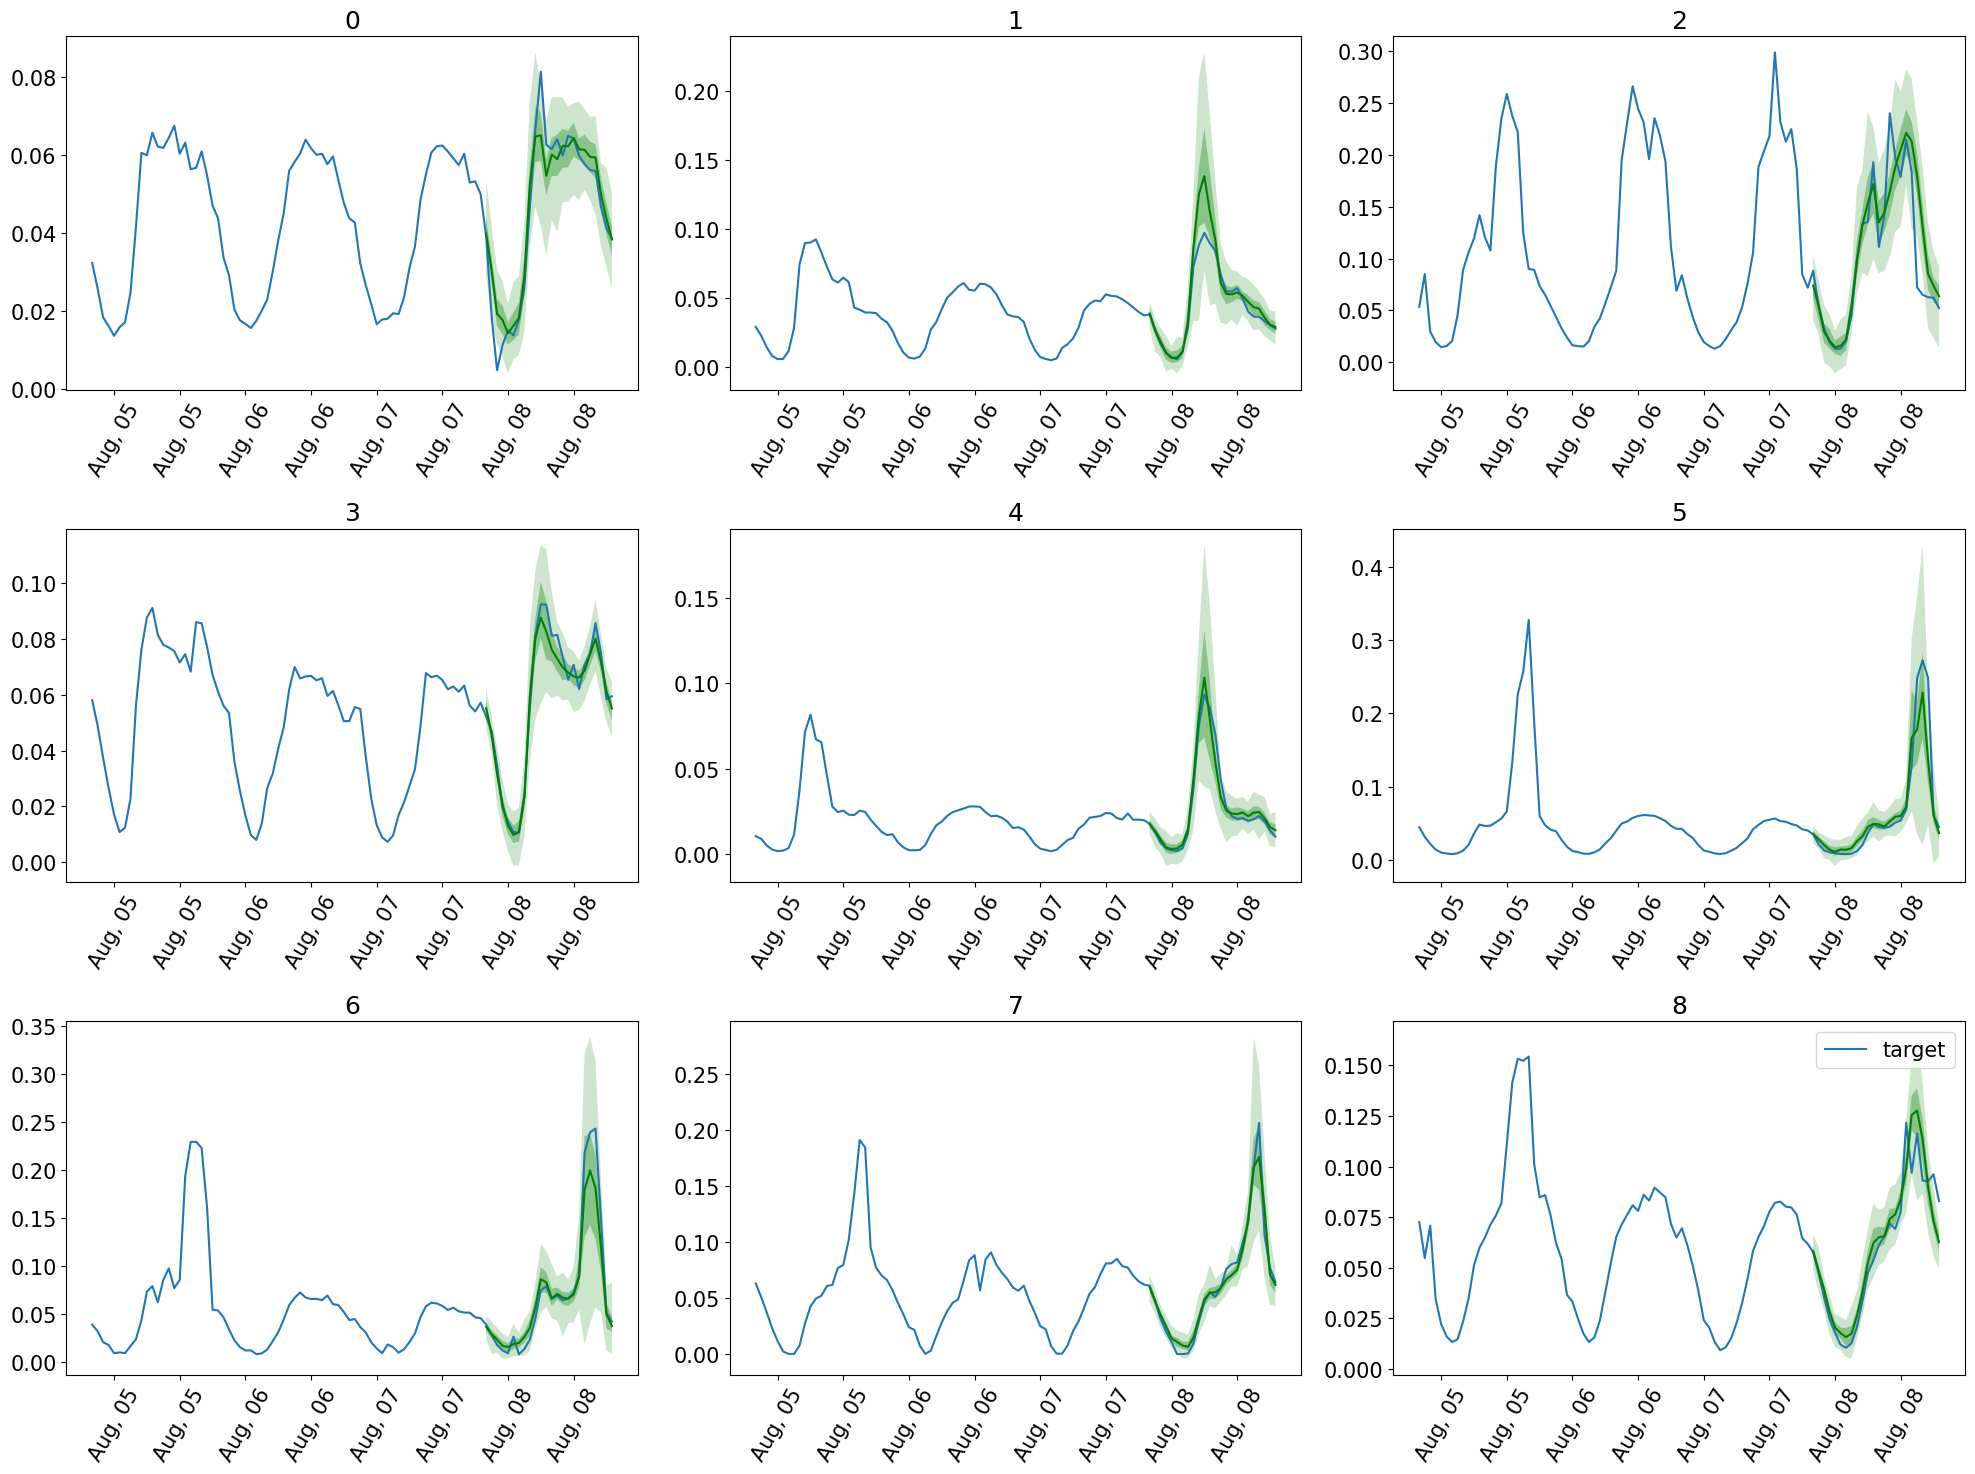

In [39]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * test_dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()